# Importing

In [1]:
import pandas as pd 
import numpy as np
import geopandas as gpd
import fiona
import os
import zipfile
from folium import Map, CircleMarker, Vega, Popup, Marker, PolyLine, Icon, Choropleth, LayerControl
from folium.plugins import MarkerCluster, HeatMap, BeautifyIcon
import shapely
import matplotlib
from ipywidgets import interact
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.tsa 
from datetime import datetime
import missingno as msno

In [2]:
pd.set_option('display.max_rows', 100)

In [3]:
gpd.io.file.fiona.drvsupport.supported_drivers['KML'] = 'rw'
class Databases:
    def __init__(self, csv, anva, smm, metro):
        self.csv = csv
        self.anva = anva 
        self.smm = smm
        self.metro = metro

    def extract_csv(self):
        file = pd.read_csv(f'data/bike_loans/{self.csv}', sep=';')
        file['Fecha_Prestamo'] = pd.to_datetime(file['Fecha_Prestamo'])
        file['Fecha_Devolucion'] = pd.to_datetime(file['Fecha_Devolucion'])
        return file
        
    
    def extract_anva(self):
        bus_routes_AMVA = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.anva}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                bus_routes_AMVA = gpd.GeoDataFrame(pd.concat([bus_routes_AMVA, df], ignore_index=True))
        return bus_routes_AMVA
    
    def extract_smm(self):
        smm_bus_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/bus_routes/medellin_bus_routes/{self.smm}'):
            for file in files:
                path = os.path.join(root, file)
                df = gpd.read_file(path, driver='KML')
                smm_bus_routes = gpd.GeoDataFrame(pd.concat([smm_bus_routes, df], ignore_index=True))
        return smm_bus_routes
    
    def extract_metro(self):
        metro_routes = gpd.GeoDataFrame()
        for root, dirs, files in os.walk(f'data/medellin_metro/{self.metro}'):
            for file in files:
                path = os.path.join(root, file)
                print(path)
                if path.endswith('.kmz'):
                    kmz = zipfile.ZipFile(path, 'r')
                    kml = kmz.open('doc.kml', 'r')
                    df = gpd.read_file(kml, driver='KML')
                    metro_routes = gpd.GeoDataFrame(pd.concat([metro_routes, df], ignore_index=True))
        return metro_routes


In [4]:
databases = Databases('bike_loans.csv','Kml Ruta AMVA','kml Ruta SMM','medellin_metro_stations')

In [5]:
bikes = databases.extract_csv()

In [6]:
bikes.dtypes

Id_Historico_Prestamo               int64
Id_Usuario                          int64
Id_Tag_Bicicleta                   object
Fecha_Prestamo             datetime64[ns]
Fecha_Devolucion           datetime64[ns]
Id_Aparcamiento_Origen              int64
Posicion_Origen                     int64
Id_Aparcamiento_Destino           float64
Posicion_Destino                  float64
Importe                           float64
DescripcionImporte                float64
operario                           object
Num_Bici_Hist                     float64
dtype: object

In [7]:
metro = databases.extract_metro()

data/medellin_metro/medellin_metro_stations/StationsMetroPlus.kmz
data/medellin_metro/medellin_metro_stations/LinesMetroPlus.kmz
data/medellin_metro/medellin_metro_stations/StationsCable.kmz
data/medellin_metro/medellin_metro_stations/LinesMetro.kmz
data/medellin_metro/medellin_metro_stations/LinesCable.kml
data/medellin_metro/medellin_metro_stations/StationsMetro.kmz
data/medellin_metro/medellin_metro_stations/StationsFootprints.kmz
data/medellin_metro/medellin_metro_stations/LinesCable.kmz
data/medellin_metro/medellin_metro_stations/StationsTranvia.kmz
data/medellin_metro/medellin_metro_stations/LineTranvia.kmz


In [8]:
smm = databases.extract_smm()

In [9]:
anva = databases.extract_anva()

## Demand : Time Series

In [10]:
bikes['Fecha_Prestamo'] 

0          2017-06-21 14:22:11
1          2017-06-21 14:07:18
2          2017-06-21 14:25:11
3          2017-06-21 13:35:52
4          2017-06-21 14:17:56
                   ...        
14225350   2021-04-20 18:46:57
14225351   2021-04-20 18:28:09
14225352   2021-04-20 18:59:53
14225353   2021-04-20 18:45:42
14225354   2021-04-20 18:39:06
Name: Fecha_Prestamo, Length: 14225355, dtype: datetime64[ns]

In order to capture **trends and seasonality** properly, we decided to focus on **pre-pandemic** data. The first case diagnosed of Covid-19 in Colombia was on March 6th, 2020. Therefore, in order to avoid any bias in the data, we decided to focus on the data prior to 2020.

In [11]:
bikes_pre = bikes[bikes['Fecha_Prestamo'].dt.year < 2020]
bikes_pre

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,0.0,NaN,jhon.castano,929.0
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,0.0,NaN,monitor,1612.0
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,0.0,NaN,NaN,1679.0
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,0.0,NaN,NaN,1076.0
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,0.0,NaN,monitor,1176.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,0.0,NaN,claudia.marin,541.0
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,0.0,NaN,claudia.marin,715.0
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,0.0,NaN,edison.graciano,3497.0
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,0.0,NaN,NaN,534.0


In [12]:
bikes_pre.shape

(11766730, 13)

In [13]:
#adding a new column to find the 
bikes_pre['loan_hour'] = bikes_pre['Fecha_Prestamo'].dt.hour
bikes_pre['loan_hour']

<ipython-input-13-b1beff32ffe2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_pre['loan_hour'] = bikes_pre['Fecha_Prestamo'].dt.hour


0           14
1           14
2           14
3           13
4           14
            ..
11767100    13
11767101    13
11767102    13
11767103    13
11767179    13
Name: loan_hour, Length: 11766730, dtype: int64

In [14]:
bikes_pre['loan_hour'].value_counts()

17    1228470
7      965999
16     920583
18     886511
12     864814
13     850919
11     797656
14     783512
15     774305
9      697068
6      674967
10     662295
8      654133
19     420379
20     287434
5      287063
21       5056
22       3689
4        1794
23         40
0          14
2          13
1           9
3           7
Name: loan_hour, dtype: int64

<AxesSubplot:title={'center':'Distribution of Demand per Hour'}, xlabel='loan_hour'>

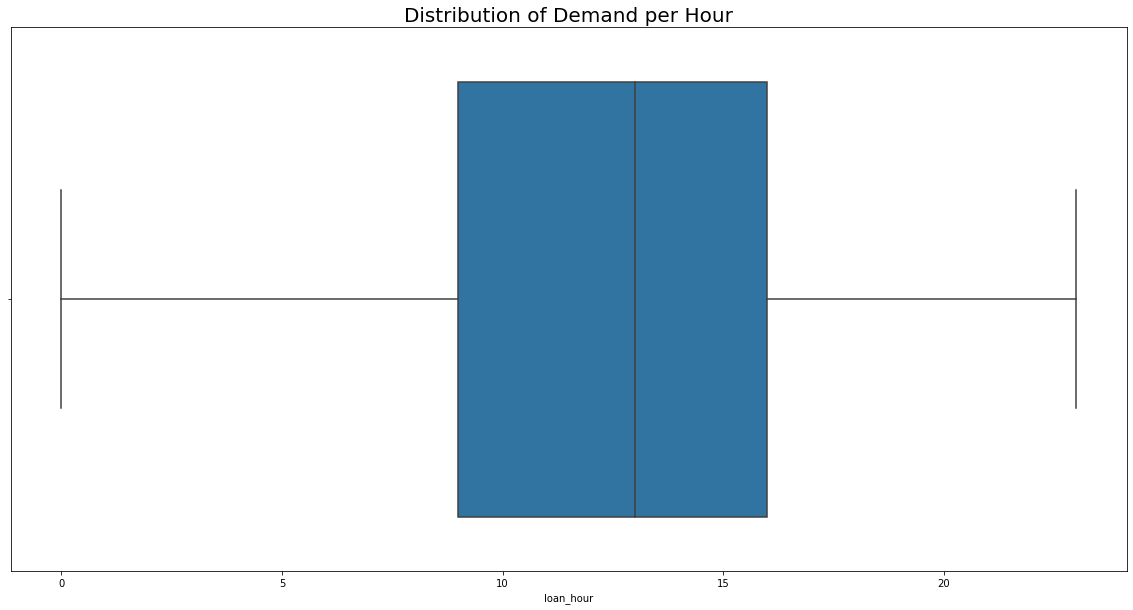

In [15]:
# exploring the times of day where demand is strongest
plt.figure(figsize=(20,10))
plt.title('Distribution of Demand per Hour', size=20)
sns.boxplot(x=bikes_pre['loan_hour'])

<AxesSubplot:title={'center':'Demand Per Hour'}, xlabel='loan_hour', ylabel='Count'>

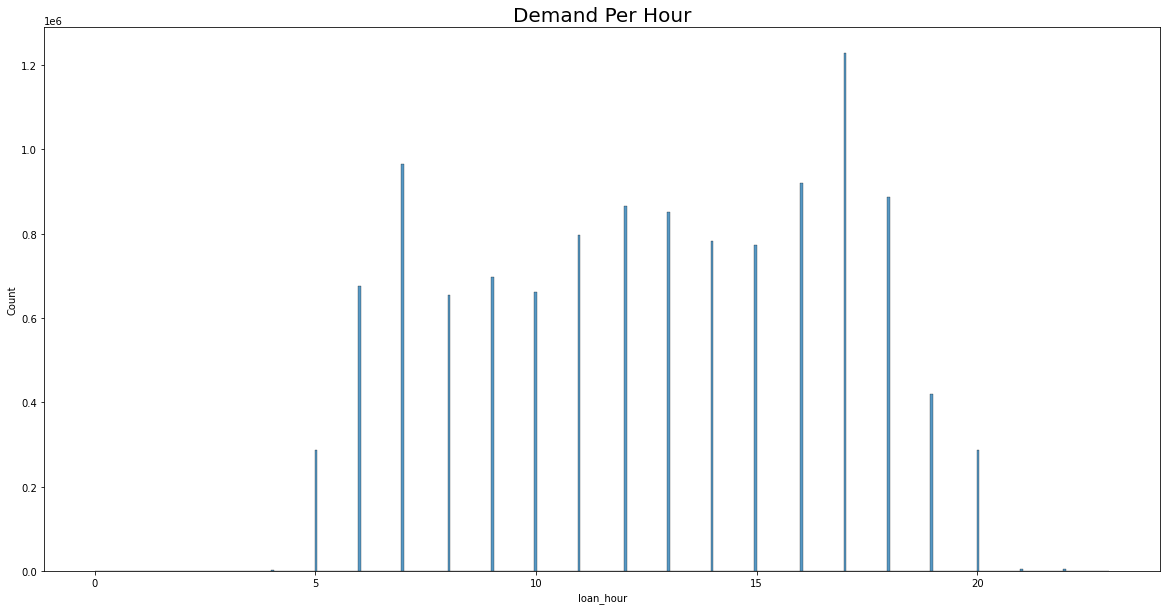

In [16]:
plt.figure(figsize=(20,10))
plt.title('Demand Per Hour', size=20)
sns.histplot(data=bikes_pre, x = 'loan_hour')

In [17]:
# initializing new column Demand so that when we group by, we can see the amount of bikes demanded per hour
bikes_pre['demand'] = 1

<ipython-input-17-c71449922adb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_pre['demand'] = 1


In [18]:
bikes_pre.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,loan_hour,demand
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,0.0,NaN,jhon.castano,929.0,14,1
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,0.0,NaN,monitor,1612.0,14,1
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,0.0,NaN,NaN,1679.0,14,1
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,0.0,NaN,NaN,1076.0,13,1
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,0.0,NaN,monitor,1176.0,14,1


In [19]:
bikes_pre['loan_date_hour'] = bikes_pre['Fecha_Prestamo'].dt.date.astype('string') + " " + bikes_pre['loan_hour'].astype('string')

<ipython-input-19-650331dcb6a3>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_pre['loan_date_hour'] = bikes_pre['Fecha_Prestamo'].dt.date.astype('string') + " " + bikes_pre['loan_hour'].astype('string')


In [20]:
bikes_pre['loan_date_hour']

0           2017-06-21 14
1           2017-06-21 14
2           2017-06-21 14
3           2017-06-21 13
4           2017-06-21 14
                ...      
11767100    2019-12-31 13
11767101    2019-12-31 13
11767102    2019-12-31 13
11767103    2019-12-31 13
11767179    2019-12-31 13
Name: loan_date_hour, Length: 11766730, dtype: string

In [21]:
bikes_pre.head()

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,loan_hour,demand,loan_date_hour
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,0.0,NaN,jhon.castano,929.0,14,1,2017-06-21 14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,0.0,NaN,monitor,1612.0,14,1,2017-06-21 14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,0.0,NaN,NaN,1679.0,14,1,2017-06-21 14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,0.0,NaN,NaN,1076.0,13,1,2017-06-21 13
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,0.0,NaN,monitor,1176.0,14,1,2017-06-21 14


In [22]:
# 100 stations
demand_per_station = bikes_pre[['demand']].groupby(bikes_pre['Id_Aparcamiento_Origen']).sum()
demand_per_station.sort_values(by = 'demand', ascending=False)

,demand
Id_Aparcamiento_Origen,
8,660489
7,565193
12,420721
3,409055
2,361221
10,347298
67,334511
13,331730
5,323056


In [23]:
bikes_pre['demand_per_station_per_time'] = bikes_pre['Posicion_Origen'].astype('string') + " " + bikes_pre['loan_date_hour']

<ipython-input-23-14f6a97f0617>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bikes_pre['demand_per_station_per_time'] = bikes_pre['Posicion_Origen'].astype('string') + " " + bikes_pre['loan_date_hour']


In [24]:
bikes_pre

,Id_Historico_Prestamo,Id_Usuario,Id_Tag_Bicicleta,Fecha_Prestamo,Fecha_Devolucion,Id_Aparcamiento_Origen,Posicion_Origen,Id_Aparcamiento_Destino,Posicion_Destino,Importe,DescripcionImporte,operario,Num_Bici_Hist,loan_hour,demand,loan_date_hour,demand_per_station_per_time
0,6501462,18701,000017B00743,2017-06-21 14:22:11,2017-06-21 14:38:29,8,1,43.0,1.0,0.0,NaN,jhon.castano,929.0,14,1,2017-06-21 14,1 2017-06-21 14
1,6501318,41811,000017AFF83C,2017-06-21 14:07:18,2017-06-21 14:39:06,56,6,54.0,NaN,0.0,NaN,monitor,1612.0,14,1,2017-06-21 14,6 2017-06-21 14
2,6501489,96620,000017AFFB6F,2017-06-21 14:25:11,2017-06-21 14:39:07,36,25,9.0,13.0,0.0,NaN,NaN,1679.0,14,1,2017-06-21 14,25 2017-06-21 14
3,6501001,16055,0000182A3B7B,2017-06-21 13:35:52,2017-06-21 14:39:22,8,1,9.0,6.0,0.0,NaN,NaN,1076.0,13,1,2017-06-21 13,1 2017-06-21 13
4,6501421,6431,000017AFE810,2017-06-21 14:17:56,2017-06-21 14:39:26,56,14,54.0,NaN,0.0,NaN,monitor,1176.0,14,1,2017-06-21 14,14 2017-06-21 14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11767100,14454800,27944,0000F69A5A88,2019-12-31 13:58:55,2019-12-31 14:25:38,40,1,50.0,1.0,0.0,NaN,claudia.marin,541.0,13,1,2019-12-31 13,1 2019-12-31 13
11767101,14454778,108800,00029A222B5E,2019-12-31 13:52:48,2019-12-31 14:40:52,28,1,50.0,1.0,0.0,NaN,claudia.marin,715.0,13,1,2019-12-31 13,1 2019-12-31 13
11767102,14454793,98449,00001619CE0A,2019-12-31 13:55:47,2019-12-31 14:41:39,113,1,28.0,1.0,0.0,NaN,edison.graciano,3497.0,13,1,2019-12-31 13,1 2019-12-31 13
11767103,14454774,129665,000036885A88,2019-12-31 13:51:28,2019-12-31 16:27:12,39,15,41.0,15.0,0.0,NaN,NaN,534.0,13,1,2019-12-31 13,15 2019-12-31 13


In [25]:
demand_per_station_per_time = bikes_pre[['demand']].groupby(bikes_pre['demand_per_station_per_time']).sum()

In [26]:
demand_per_station_per_time.reset_index(inplace=True)

In [27]:
demand_per_station_per_time

,demand_per_station_per_time,demand
0,1 2014-05-30 15,1
1,1 2014-05-30 17,2
2,1 2014-05-30 22,2
3,1 2014-06-01 20,6
4,1 2014-06-02 11,1
...,...,...
615783,9 2019-12-31 5,2
615784,9 2019-12-31 6,2
615785,9 2019-12-31 7,4
615786,9 2019-12-31 8,7


In [28]:
demand_per_station_per_time[['station','date','time']] = demand_per_station_per_time.demand_per_station_per_time.str.split(" ",expand=True,)

In [29]:
demand_per_station_per_time

,demand_per_station_per_time,demand,station,date,time
0,1 2014-05-30 15,1,1,2014-05-30,15
1,1 2014-05-30 17,2,1,2014-05-30,17
2,1 2014-05-30 22,2,1,2014-05-30,22
3,1 2014-06-01 20,6,1,2014-06-01,20
4,1 2014-06-02 11,1,1,2014-06-02,11
...,...,...,...,...,...
615783,9 2019-12-31 5,2,9,2019-12-31,5
615784,9 2019-12-31 6,2,9,2019-12-31,6
615785,9 2019-12-31 7,4,9,2019-12-31,7
615786,9 2019-12-31 8,7,9,2019-12-31,8


In [30]:
# as we can see the greatest demand is for station 1 between 17-18
demand_per_station_per_time.sort_values(by = 'demand', ascending =False).head(100)

,demand_per_station_per_time,demand,station,date,time
22922,1 2019-08-21 17,1511,1,2019-08-21,17
23753,1 2019-10-15 17,1499,1,2019-10-15,17
23338,1 2019-09-17 17,1470,1,2019-09-17,17
23375,1 2019-09-19 17,1464,1,2019-09-19,17
22829,1 2019-08-14 17,1458,1,2019-08-14,17
22903,1 2019-08-20 17,1457,1,2019-08-20,17
22810,1 2019-08-13 17,1457,1,2019-08-13,17
23319,1 2019-09-16 17,1457,1,2019-09-16,17
23644,1 2019-10-07 17,1452,1,2019-10-07,17
23014,1 2019-08-27 17,1447,1,2019-08-27,17


In [74]:
df = demand_per_station_per_time.copy()
df

,demand_per_station_per_time,demand,station,date,time
0,1 2014-05-30 15,1,1,2014-05-30,15
1,1 2014-05-30 17,2,1,2014-05-30,17
2,1 2014-05-30 22,2,1,2014-05-30,22
3,1 2014-06-01 20,6,1,2014-06-01,20
4,1 2014-06-02 11,1,1,2014-06-02,11
...,...,...,...,...,...
615783,9 2019-12-31 5,2,9,2019-12-31,5
615784,9 2019-12-31 6,2,9,2019-12-31,6
615785,9 2019-12-31 7,4,9,2019-12-31,7
615786,9 2019-12-31 8,7,9,2019-12-31,8


In [75]:
df[df['station'] == '1']
# as you can see we have gaps in the time series, however, I am reading about imputing new rows to fill those.
# In 2014, there will be a lot more gaps than in 2019, since the project was developed.

,demand_per_station_per_time,demand,station,date,time
0,1 2014-05-30 15,1,1,2014-05-30,15
1,1 2014-05-30 17,2,1,2014-05-30,17
2,1 2014-05-30 22,2,1,2014-05-30,22
3,1 2014-06-01 20,6,1,2014-06-01,20
4,1 2014-06-02 11,1,1,2014-06-02,11
...,...,...,...,...,...
24884,1 2019-12-31 5,80,1,2019-12-31,5
24885,1 2019-12-31 6,167,1,2019-12-31,6
24886,1 2019-12-31 7,200,1,2019-12-31,7
24887,1 2019-12-31 8,156,1,2019-12-31,8


<AxesSubplot:>

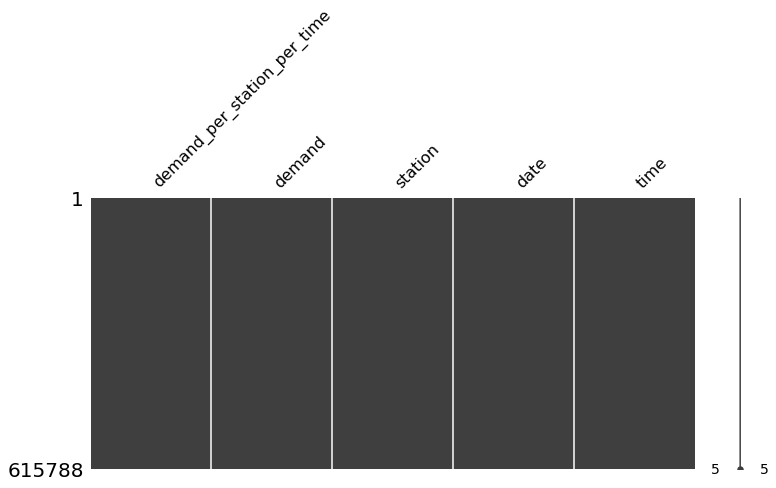

In [76]:
msno.matrix(df,figsize=(12,5))

Since it will be difficult to built a time-series with all the stations, maybe we can build a function where you impute
which station you would like to forecast the demand for, and it tells you. 

What I was also thinking is to have the same df as above, but add new columns with like number of times it reached this destination IDs. 
So for example, have another 100 columns (each representing a station of **destination demand**. 

The last row has 199 demand, but how do we know where they are goin ?

Other interesting columns we can add are **seasons, holidays, working, days, temp, windy speed**

https://www.kaggle.com/viveksrinivasan/eda-ensemble-model-top-10-percentile

In [77]:
df.dtypes

demand_per_station_per_time    object
demand                          int64
station                        object
date                           object
time                           object
dtype: object

In [78]:
df['time'] = df['time'].astype(int)

In [79]:
# aggregated demand per hour between 2014-2019 
ad_per_hour = df.groupby('time').sum()
ad_per_hour.sort_index(ascending=True)

,demand
time,
0,14
1,9
2,13
3,7
4,1794
5,287063
6,674967
7,965999
8,654133


<AxesSubplot:xlabel='time', ylabel='demand'>

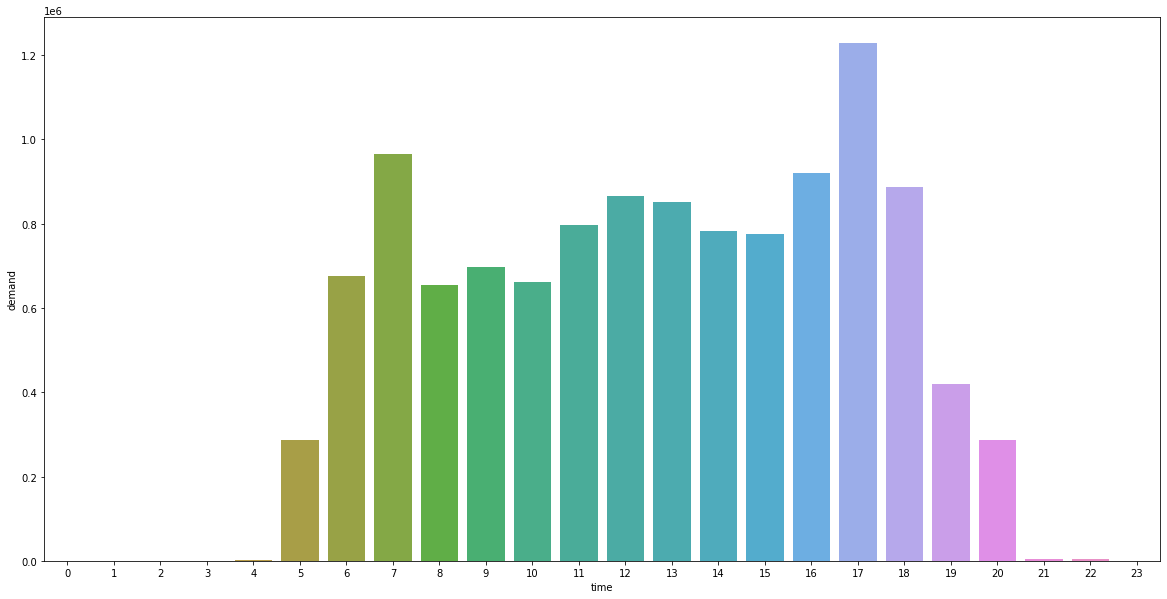

In [80]:
plt.figure(figsize=(20,10))
sns.barplot(data=ad_per_hour, x=ad_per_hour.index, y='demand')

let's keep the last 30% values out for test purposes
Contiguous (train ➔ test) split mandator

train_size = 0.7

index = round(train_size*df.shape[0])

df_train = df.iloc[:index]

df_test = df.iloc[index+1:]

In [85]:
def convert_to_date(x):
    return datetime.strptime(x, '%Y-%m-%d %H')

In [82]:
df['year_month_day_hour'] = df['demand_per_station_per_time'].str[2:]

In [83]:
df.drop(columns='demand_per_station_per_time', inplace=True)

In [86]:
df['year_month_day_hour'].apply(convert_to_date)

ValueError: time data ' 2014-11-05 15' does not match format '%Y-%m-%d %H'